## ASTR 2100, Winter 2020

## Homework Assignment 2 (70 points + 10 extra-credit points)

### Distributed: Monday, January 27

### Due: Wednesday,  Feb 5 at 11:59pm 

#### Exercises you need to do for the assignment grade are tasks in Exercises 1 and 2 along with relative difficulty of each task in the exercise denoted by associated points
#### Optional exercises are marked as extra-credit

#### Please submit you notebook (i.e. its *.ipynb file) as an attachment via Canvas. You can also attach other files, if needed to your submission. Make sure that all of the cells in the notebook have output that you want, when you run all cells just before the submission


#### Jupyter notebooks with class notes and assignments: https://github.com/a-kravtsov/a211w20

#### Slack workspace for this class: https://a211w20.slack.com


#### Instructor: Andrey Kravtsov (kravtsov@uchicago.edu)

#### TAs: Dimitrios Tanoglidis (dtanoglidis@uchicaago.edu), Georgios Zakharegkas (gzakharegkas@uchicago.edu)

import packages needed by the codes below. Run this cell first before using these codes. 

In [1]:
import numpy as np

# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
%matplotlib inline

from codes.plot_utils import plot_pretty
plot_pretty(fontsize=12)

## Exercise 1: Using splines for interpolation and estimates of  derivatives and integrals
### (40 points)

**Background.** I introduced splines as a way to construct piecewise polynomial approximation that is continuous and smooth and also has smooth first derivative (see the <a href="https://github.com/a-kravtsov/a211w20/blob/master/03_approximation.ipynb"><tt>03_approximation.ipynb</tt></a> notebook). Splines not only provide a general flexible and accurate way to approximate a function represented by some tabulated values at the training points, but can also automatically provides approximations for the function first three derivatives and its integral. Moreover, splines can be used as a tool for numerical solution (finding roots) of equations and inverting functions. In this sense splines are one of the "Swiss army knife"-type numerical methods that are very useful to have in one's toolbox. 

In this exercise you will practice using splines for these tasks. 

### What you are learning in this exercise

* To use polynomials and splines to approximate a function using SciPy routines
* Use splines to obtain accurate and smooth estimate of the function derivative
* Use spline to obtain accurate estimate of the function integral for integration intervals that fall within the interval, in which the approximating spline was constructed.  
* Use splines to invert a complicated function (which is equivalent to finding a root of a function). Inversion is when we instead of estimating $y=f(x)$, find $x$ that satisfies such equation given a $y$ value. 

### Data used in this exercise

For this exercise we will use a function $P(k)$ that is tabulated in a data file. 

For the purposes of this exercise it is not needed to know what this function is. This is something called "power spectrum" - the concept we will come back to when we will discuss Fourier transforms (also see below task 2). This particular power spectrum is often used in astrophysical calculations related to galaxies and the spatial structures in galaxy distribution. The tabulated values in the file were computed using a sophisticated code <a href="https://camb.info/">CAMB</a> that solves a complicated system of differential equations. 

In [2]:
# read in function that will be used for this exercise
k, Pk = np.loadtxt('data/test_matterpower_logintk1000.dat', usecols=(0, 1),  unpack=True)

# their log10 values that will be used 
lk, lPk = np.log10(k), np.log10(Pk)

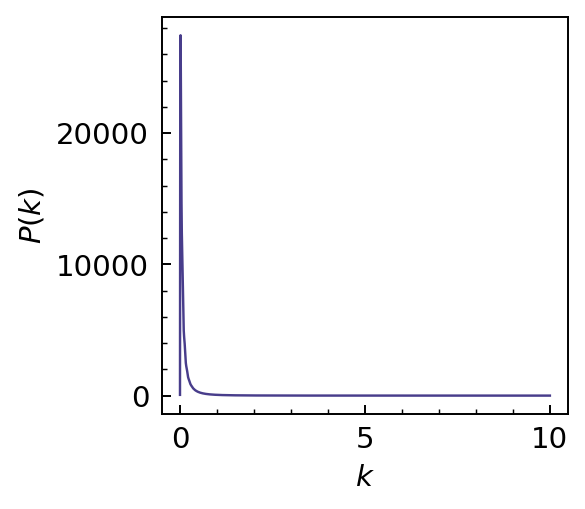

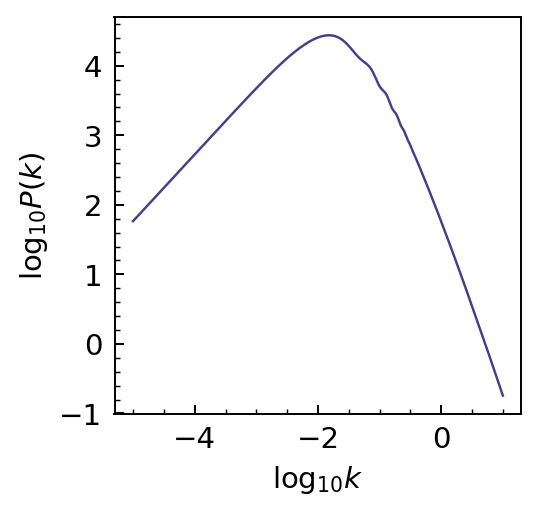

In [3]:
from codes.plot_utils import plot_line_points
plot_pretty(fontsize=12)

plot_line_points(k, Pk, xlabel=r'$k$', ylabel=r'$P(k)$', figsize=3)
plot_line_points(lk, lPk, xlabel=r'$\log_{10} k$', ylabel=r'$\log_{10} P(k)$', figsize=3)

The plots above show that $P(k)$ is changing very rapidly for small values of $k$ and slowly for large values. Functions that change rapidly are more difficult to approximate accurately because more training points are needed in the areas of rapid change. So it is often useful to examine how $\log_{10}$ of the function behaves as a function of $\log_{10}$ of the parameter (i.e., examine function in logarithmic space). This is what is done in the second plot above. We can see that in this case, $\log_{10} P(k)$ changes relatively slowly and so approximating $\log_{10} P(k)$ as a function of $\log_{10} k$ is preferrable. 

Overall, $\log_{10} P(k)$ looks like two power law functions of different exponent smoothly joined in the middle, but notice little "wiggles" around $\log_{10} k\sim -1$. These are real features of this function and make it not entirely trivial to approximate with, say, a polynomial of low order. 

Next, let's see how <tt>k</tt> and <tt>lk</tt> are spaced. 

In [4]:
# np.diff computes difference of 2 subsequent elements of lk
dlk = np.diff(lk) 
# if we look at the first 10 elements, it may seem that l (and lk) are evenly spaced
print(dlk[:10])
# however, this is not the case
print(dlk.min(), dlk.max())
# spacing of data points is not uniform overall

[0.04304196 0.04303239 0.04305963 0.04303769 0.04302909 0.04304367
 0.04303872 0.04302599 0.04304582 0.04303598]
0.0003967464299742818 0.04306143598772039


### Polynomial interpolation

In class on Friday I showed that straitforward solution of the linear system of equations for the polynomial coefficients by computing the inverse of the Vandermonde matrix as in the code below (this is similar to the code for approximating $d_L$ in <tt>03_approximation.ipynb</tt> notebook that I showed in class on Friday). 

For small systems of equations this works fine. For example, consider a system of two equations

\begin{eqnarray}
f_0 &=& a_0 + a_1 x_0\\
f_1 &=& a_0 + a_1 x_1
\end{eqnarray}
Suppose we have 2 training points, $x_0=1$, $x_1=2$, and function values at these points $f_0=3$, $f_1=5$. We can easily solve this system ourselves for the coefficients: $a_0=2$, $a_1=1$. 

The code I used on Friday in class can do this as well.

In [5]:
xtr = np.array([1., 2.])
ftr = np.array([3., 5.])

# construct the Vandermonde matrix for vector xtr
V = np.vander(xtr, N=np.size(xtr), increasing=True) 
# solve for the polynomial (linear order in this case)
a = np.dot(np.linalg.inv(V), ftr) 
# the coefficients are in reverse order in a, so we can reverse it for printing using ::-1 slicing
print(a[::-1])

[2. 1.]


As you saw on Friday and as the code below shows again, this way of solving for coefficients is numerically unstable, and fails in interpolation using as few as 20 training points. Example below will produce reasonably accurate interpolating polynomial for the number of training points <tt>ntr<20</tt>, but will fail dramatically for any larger number of the training points. 

In [6]:
# set up vector of training points
xmin, xmax, ntr = 0., 2.*np.pi, 21
xtr = np.linspace(xmin, xmax, ntr)
# for testing points use sin(x) function
# compute function values at training points
ftr = np.sin(xtr)

# set up a vector of test points
nt = 100 # should be different from nt
xt = np.linspace(xmin, xmax, nt)

# construct Vandermonde matrix for xtr vector
V = np.vander(xtr, N=ntr, increasing=True) 

# solve for polynomial coefficients vector a, as a=V^{-1}f
a = np.dot(np.linalg.inv(V), ftr) 

# np.poly1d initializes a 1d polynomial class with input coefficients
# [::-1] reverses order of the coefficients, as required by this routine
pfit = np.poly1d(a[::-1]) 
# now compute interpolating polynomial approximation at test values xt
poly_int = pfit(xt)

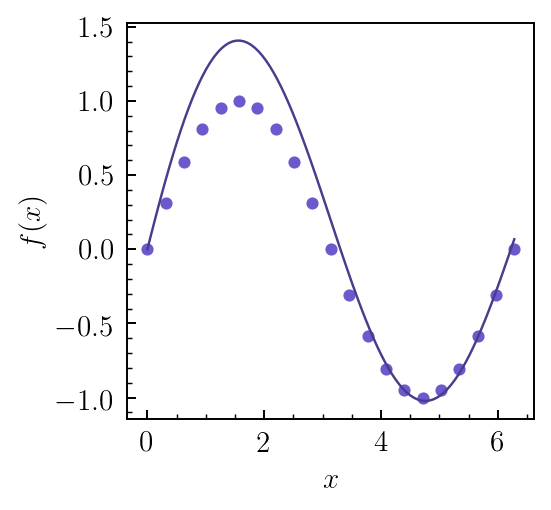

In [7]:
plot_line_points(xt, poly_int, xp=xtr, yp=ftr, points=True,
                 xlabel=r'$x$', ylabel=r'$f(x)$', figsize=3)

This is because, matrix $V$ involves a wide range of powers of $x$ and thus its elements have a vast range of values. Such matrices have large *condition* value (see <tt>03_approximaton.ipynb</tt> for the definition of condition) and are called "ill- or poorly conditioned". 

However, if we instead using <tt>numpy.linalg.solve</tt> routine to solve the same system of equations, namely if we replace the following line in the <tt>03_approximation.ipynb</tt>

    a = np.dot(np.linalg.inv(V), dLtr) # a = V^{-1} f

with 

    a = np.linalg.solve(V, dLtr)
    
this fixes the problem at least until the number of training of points is much larger than 20. 
This is because <tt>numpy.linalg.solve</tt> uses a more numerically stable algorithm with LU decomposition of the Vandermonde matrix to solve the system of equations (the routine uses fortran-based LAPACK library, see <a href="https://software.intel.com/en-us/node/468876">here</a>). 

Likewise, if we replace that line with 

    a = np.linalg.lstsq(V, dLtr, rcond=None)[0] 
   
this solves the problem as well because this routine uses numerically robust Singular Value Decomposition (SVD) method to solve the system of normal equations. Note that we can control the order of approximating polynomial in this case, by limiting the size of the Vandermonde matrix to the required order <tt>poly_order</tt> as shown here: 
    V = np.vander(xtr, N=poly_order, increasing=True)

Let's see if this will also work for approximating function $P(k)$ that was read above. 


**Task 1a. (10 points)** Based on the code in the 03 notebook reproduced above, write a function that constructs interpolating (using <tt>np.linalg.solve</tt>) or approximating (using <tt>np.linalg.lstsq</tt>) polynomial for input vector of test points and corresponding tabulated function values with the following interface:

    def poly_approx(xtr, ftr, xt, method='interpolation', poly_order=1):
        """
        function constructing an approximating polynomial for the input 
        vector of training values of the approximated function ftr, 
        tabulated at the vector of training points xtr and compute the values
        of constructed polynomial at the input vector of test values xt
    
        Parameters:
        -----------
        xtr, ftr: array like
                    vectors of training points and tabulated function values
        xt: array like
                    vector of test points
        method: string
                defining the method to be used in construction of the polynomial
                'interpolation' - construct interpolating polynomial using np.linalg.solve
                'regression' - construct approximating polynomial np.linalg.lstsq
        poly_order: integer
                    order of the approximating polynomial. This parameter is ignored
                    for method='interpolation', but is used for 'regression'
                    must be 0<=poly_order<=np.size(xtr)
        Returns:
        --------
        ft: array like
            values of the polynomial at xt 
        a:  array like
            polynomial coefficients
        """

Test this function using $\sin(x)$ as a  test function as shown below and demonstrate that your routine works (i.e., produces sensible results). Try changing the number of training points used <tt>ntr</tt> from 20 to smaller values. Identify and report the smallest <tt>ntr</tt> for which you get *interpolating* polynomial that still looks qualitatively as a sine (for example, it has a clear minimum and maximum in the $[0,2\pi]$ interval). Try to come with your interpretation of the meaning of the minimum value that you find and briefly describe it. 

In [15]:
def poly_approx(xtr, ftr, xt, method='interpolation', poly_order=1):
    """
    function constructing an approximating polynomial for the input 
    vector of training values of the approximated function ftr, 
    tabulated at the vector of training points xtr and compute the values
    of constructed polynomial at the input vector of test values xt

    Parameters:
    -----------
    xtr, ftr: array like
                vectors of training points and tabulated function values
    xt: array like
                vector of test points
    method: string
            defining the method to be used in construction of the polynomial
            'interpolation' - construct interpolating polynomial using np.linalg.solve
            'regression' - construct approximating polynomial np.linalg.lstsq
    poly_order: integer
                order of the approximating polynomial. This parameter is ignored
                for method='interpolation', but is used for 'regression'
                must be 0<=poly_order<=np.size(xtr)
    Returns:
    --------
    ft: array like
        values of the polynomial at xt 
    a:  array like
        polynomial coefficients
    """
    ntr = len(xtr) # define number of training set points
     #set up Vandermonde matrix
    if method == 'interpolation':
        V = np.vander(xtr, ntr, increasing=True)
        #print(V[1:10])
        a = np.linalg.solve(V, ftr) # a = V^{-1} ftr
    elif method == 'regression':
        V = np.vander(xtr, poly_order, increasing=True)
        a = np.linalg.lstsq(V, ftr, rcond=None)[0] 
    pfit = np.poly1d(a[::-1]) #define polynomial function poly
    ft = pfit(xt) #evaluate fitting function poly
    return ft, a

In [16]:
# test your routine using code below

xmin, xmax, ntr = 0., 2.*np.pi, 20
xtr = np.linspace(xmin, xmax, ntr)
ftr_int = np.sin(xtr)
# this vector is sine function + a little bit of Gaussian random noise (so mimics approximating noisy data)
ftr_fit = np.sin(xtr) + np.random.normal(scale=0.05, size=np.size(xtr))

nt = 1000 # should be different from nt
xt = np.linspace(xmin, xmax, nt)

poly_int, a_int = poly_approx(xtr, ftr_int, xt, method='interpolation')

poly_order=17
poly_fit, a_fit = poly_approx(xtr, ftr_fit, xt, method='regression', poly_order=poly_order)

In [ ]:
# plot results
plot_line_points(xt, poly_int, xp=xtr, yp=ftr_int, points=True,
                 xlabel=r'$x$', ylabel=r'$f(x)$', figsize=3)

In [ ]:
plot_line_points(xt, poly_fit, xp=xtr, yp=ftr_fit, points=True,
                 xlabel=r'$x$', ylabel=r'$f(x)$', figsize=3)

**Task 1b. (5 points)** Now apply the routine you implemented to interpolate $P(k)$ read in below. If you don't manage to get the working implementation in 1a, you can use <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html"><tt>np.polyfit</tt></a> routine for this exercise. 

In [17]:
nkt = 1000
kt = np.linspace(k.min(), k.max(), nkt)

In [ ]:
poly_int, a_int = poly_approx(lk, lPk, kt, method='regression', poly_order=np.size(kt))

In [ ]:
print(a_int, np.size(a_int))

In [ ]:
plot_line_points(kt, poly_int, xlabel=r'$x$', ylabel=r'$f(x)$', figsize=3)

What happens? Try doing this for $\log_{10} k$ and $\log_{10} P(k)$ instead of $P(k)$. Then try with regression. 

In [18]:
lkt = np.linspace(lk.min(), lk.max(), nkt)
poly_intl, a_intl = poly_approx(lk, lPk, lkt, method='interpolation')

In [ ]:
poly_int, a_int = poly_approx(lk, lPk, lkt, method='regression', poly_order=20)

In [ ]:
plot_line_points(lkt, poly_int, xlabel=r'$x$', ylabel=r'$f(x)$', figsize=4)

Do you get a sensible result? Think about what the routine is doing and try to come up with an explanation for the outcome of this exercise. (7 points)

Try regression with smaller poly_order values and find polynomial order for which at least somewhat sensible approximation can be obtained. What is that order? Think about a possible explanation for why this works for small order (3 points). 

### SciPy routines for spline interpolation and approximation

Spline interpolation is implemented in the SciPy library <a href="http://scipy.github.io/devdocs/interpolate.html"><tt>scipy.interpolate</tt></a> in routines <a href="https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.interpolate.interp1d.html"><tt>interp1d</tt></a> and <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html"><tt>UnivariateSpline</tt></a>. Scipy   has more spline routines for more specialized tasks (see the list <a href="http://scipy.github.io/devdocs/interpolate.html">here</a> and examples of their use <a href="https://docs.scipy.org/doc/scipy-1.0.0/reference/tutorial/interpolate.html">here</a>), but the routines listed here are most frequently used for 1-dimensional function interpolation/approximation. 

<a href="https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.interpolate.interp1d.html"><tt>interp1d</tt></a> is a routine written in python, although parts of it are written in <a href="https://cython.org/">Cython</a> and use a couple of <a href="">Fitpack library routines</a> and can perform only spline interpolation (i.e. approximation matching the function values at the training values to machine precision). 

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html"><tt>UnivariateSpline</tt></a> is a class-based python wrapper around routines <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splev.html"><tt>splev</tt></a>, <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splrep.html#scipy.interpolate.splrep"><tt>splrep</tt></a>, and <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splprep.html#scipy.interpolate.splprep"><tt>splprep</tt></a> that use old, efficient fortran-based Fitpack library of interpolation routines. This function allows construction of the spline that is not interpolating data, but approximating it using the least squares regression discussed in class on Friday. The effective weights of tabulated function data points are set by the input parameter <tt>s</tt>.   

For <tt>s=0</tt> <tt>UnivariateSpline</tt> is equivalent to routine
SciPy <a href="http://scipy.github.io/devdocs/generated/scipy.interpolate.InterpolatedUnivariateSpline.html#scipy.interpolate.InterpolatedUnivariateSpline"><tt>InterpolatedUnivariateSpline</tt></a> that constructs spline that matches the function values at the training points to machine precision.

For <tt>s>0</tt> <tt>UnivariateSpline</tt> constructs spline that satisfies condition for the $N+1$ training points $x_i$:

$$\sum\limits_{i=0}^N w_i [f_i-{\rm spline}(x_i)]^2 \leq s$$

by solving the system of normal equations for the spline coefficients. 

Below are my routines that compute coefficients of the interpolating 
natural cubic spline and the spline itself, given the vector of these coefficients.  

In [19]:
def cubic_spline_coefficients(xi, fi):
    """
    compute coefficients of the interpolating natural cubic spline
    see Appendix in the note for the derivation and details of the algorithm
    
    Parameters: 
        xi, fi: numpy float vectors
                tabulated points and function values
            
    Returns:
        a, b, c, d: numpy float vectors
                cubic spline coefficients 
                dx = x - xi[i]
                fx = a[i] + dx*(b[i] + c[i]*dx + d[i]*dx*dx)

    """
    delx = np.diff(xi); delf = np.diff(fi)
    # form matrices to solve for spline coefficients
    vx = np.zeros_like(xi)
    # form rhs vector using python's array slicing 
    vx[1:-1:] = 3.*(delf[1::]/delx[1::] - delf[:-1:]/delx[:-1:])
    # construct 3 diagonals
    nx = np.size(xi)
    diags = np.zeros((3, nx))
    diags[1,0] = 1.; diags[1,-1] = 1.
    diags[1,1:-1:] = 2. * (delx[1::] + delx[:-1:])
    diags[0,1:] = delx[:]
    diags[2,1:-1] = delx[1:]
    # solve for coefficients c using Thomas algorithm for tri-diagonal matrices
    # see https://www.cfd-online.com/Wiki/Tridiagonal_matrix_algorithm_-_TDMA_(Thomas_algorithm)
    ac, bc, cc, dc = map(np.array, (diags[0,:], diags[1,:], diags[2,:], vx)) # copy arrays
    for k in range(1, nx):
        mk = ac[k] / bc[k-1]
        bc[k] = bc[k] - mk * cc[k-1] 
        dc[k] = dc[k] - mk * dc[k-1]
    
    c = np.zeros_like(bc)
    c[-1] = dc[-1] / bc[-1]

    for k in range(nx-2, -1, -1):
        c[k] = (dc[k]-cc[k]*c[k+1])/bc[k]

    # now get the rest of the coefficients
    b = delf[::]/delx[::] - (c[1::] + 2.*c[:-1:])*delx[::]/3.
    d = (c[1::] - c[:-1:])/(3.*delx[::]) 
    a = fi
    return a, b, c, d

In [20]:
def cubic_spline(xt, xi, a, b, c, d):
    """
    piecewise linear approximation of f(x) given input of tabulated values of xi and fi
    note that xi are expected in ascending order
    
    Returns:
        vector of spline values at test points x 

    """
    n = np.size(xi) - 1
    fxt = np.empty_like(xt)
    for j, x in enumerate(xt):
        for i in range(n):
            if (x >= xi[i]) and (x <= xi[i+1]):
                # reusing computations is always a good idea, but here we also can return dfdx
                dx = x - xi[i]
                fxt[j] = a[i] + dx*(b[i] + c[i]*dx + d[i]*dx*dx)
        
    return fxt

Here is the test that the spline interpolation produces good results for interpolation of <tt>Plk</tt> as a function of <tt>lk</tt>

In [21]:
a, b, c, d = cubic_spline_coefficients(lk, lPk)

spline_int = cubic_spline(lkt, lk, a, b, c, d)

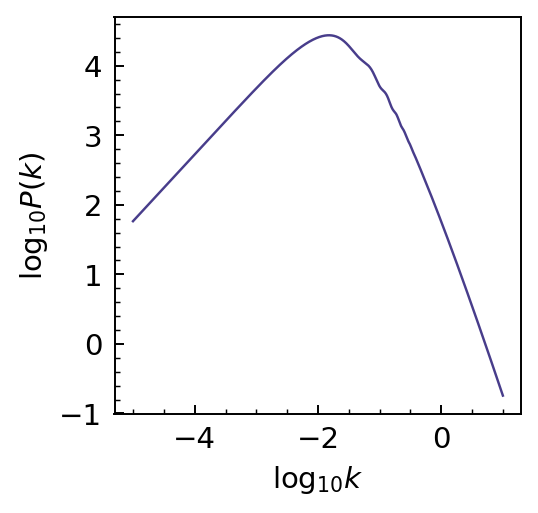

In [22]:
plot_line_points(lkt, spline_int, 
                 xlabel=r'$\log_{10} k$', ylabel=r'$\log_{10} P(k)$', figsize=3)

Note that once we have the spline coefficients for a given interval $a_i$, $b_i$, $c_i$, and $d_i$, we can compute derivatives of the interpolating spline as well as its integral. For interpolating spline 

$$s_i(x) = a_i + b_i(x-x_i) + c_i(x-x_i)^2 + d_i(x-x_i)^3,$$

we have for derivatives

\begin{eqnarray}
f^\prime(x\in[x_i,x_{i+1}])\approx s^\prime_i(x)&=&b_i + 2c_i(x-x_i)+3d_i(x-x_i)^2,\\
f^{\prime\prime}(x\in[x_i,x_{i+1}])\approx s^{\prime\prime}_i(x)&=&2c_i+6d_i(x-x_i),\\
f^{\prime\prime\prime}(x\in[x_i,x_{i+1}])\approx s^{\prime\prime\prime}_i(x)&=&6d_i
\end{eqnarray}

It is also straightforward to use interpolating spline to estimate the integral of the approximated function. For example, the integral in the interval $[x_i,x_{i+1}]$ (using change of variables $x\rightarrow\xi=x-x_i$:

$$\int\limits_{x_i}^{x_{i+1}}f(x)dx\approx \int\limits_{x_i}^{x_{i+1}}s_i(x)dx = \int\limits_{0}^{x_{i+1}-x_i}s_i(\xi)d\xi=a_i(x_{i+1}-x_i)+\frac{1}{2}b_i(x_{i+1}-x_i)^2+\frac{1}{3}c_i(x_{i+1}-x_i)^3+\frac{1}{4}d_i(x_{i+1}-x_i)^4$$

**Task 1c. (10 points)** Add calculation of the first, second, and third derivatives based on the spline interpolation to the routine <tt>cubic_spline</tt> above (3 points). Write a routine to estimate integral of $f(x)$ in the interval $[a,b]$ using interpolating cubic spline for $f(x)$ and its coefficient vectors $a$, $b$, $c$, $d$. (4 points).

Plot the first three derivatives of $\log_{10} P$ for some function (for example, the sine) and comment on their behavior (smoothness, continuity). Test the accuracy of the integral for a function for which you know the exact answer (e.g., $\sin x$ or $e^x$.) (3 points). 

**Task 1d. (5 points)** Suppose we want to compute the *logarithmic slope* of $P(k)$:

$$\frac{d\log_{10}P}{d\log_{10} k}=\frac{d\ln P}{d\ln k}=\frac{k}{P}\,\frac{dP}{dk}.$$

Compute this derivative using your routine implemented in 1c using <tt>lk</tt> and <tt>lPk</tt> vectors and plot this derivative as a function of <tt>lk</tt>. Compare your plot to the left panel of Figure 4 in <a href="https://arxiv.org/pdf/1407.4730">this paper</a>. It should look roughly similar, but with some differences. Describe the differences. Briefly describe what causes them. 

Note that if you don't complete 1c, you can construct spline interpolation of <tt>lk</tt> and <tt>lPk</tt> using SciPy <tt>UnivariateSpline</tt> with <tt>s=0</tt> and use its <tt>derivative()</tt> method to compute the derivative (see Task 1e below). 

**Task 1e (5 points)** Use SciPy <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html"><tt>UnivariateSpline</tt></a> routine to approximate <tt>lk</tt> and <tt>lPk</tt> and this class'  <tt>derivative()</tt> method to construct approximation for the derivative, as illustrated below, to compute the derivative $$d\log_{10}P/d\log_{10} k$$. Compute and plot the derivative for <tt>s=0.</tt>, <tt>s=0.0001</tt>, <tt>s=0.001</tt>, and <tt>s=0.01</tt> and comment on how the derivative changes for different values of the smoothing parameter <tt>s</tt>. Try to explain the behavior you observe. 

In [ ]:
# example of use of derivative method of UnivariateSpline 
from scipy.interpolate import UnivariateSpline

ntr = 4
xtr = np.linspace(0.,2.*np.pi, ntr)
spl = UnivariateSpline(xtr, np.sin(xtr), s=0.) # spline approximating sine
dspl = spl.derivative() # spline approximating dsin(x)/dx=cos(x)

nt = 100
xt = np.linspace(0.,2.*np.pi, nt)

In [ ]:
plot_line_points(xt, dspl(xt), xlabel=r'$x$', ylabel=r'$f^\prime(x)$', 
                 figsize=3)

In [ ]:
spl = UnivariateSpline(lk, lPk, s=0.001)
dspl = spl.derivative()

plot_line_points(lkt, dspl(lkt), xlabel=r'$\log_{10} k$', ylabel=r'$\log_{10}P(k)$', 
                 figsize=3)

**Task 1f. (5 points)** Using spline to invert function. Using spline we can invert a function or, for $y=f(x)$ compute $x$ for a given $y$. For this we need to generate vectors of $x$ and $y$ and construct interpolating spline for $y$ as the argument and $x$ as a function value. The spline can then be used for input $y$ values to estimate corresponding $x$. ***This, of course, assumes that function is monotonic and that a unique value of $x$ can be obtained for a given $y$.*** So these assumptions must be satisfied for this approach to work.  

Construct interpolating spline for $y=\sin(x)$ on the interval $[0,\pi/2]$ and use it to compute $x$ for $y=1$, $y=0$, $y=0.5$. Compare the values you get to the output of <tt>np.arcsin</tt> for these values of $y$. 

## Exercise 2 (30 points)

**Background.** During the last week we saw that computation of the luminosity distance $d_L(z,H_0,\Omega_{\rm m0},\Omega_\Lambda)$ is quite expensive when we need to compute it for many parameter combinations, as is required, for example, when we want to find the combination that describe observational measurements of supernovae type Ia. 

This motivates constructing accurate approximations for $d_L(z,H_0,\Omega_{\rm m0},\Omega_\Lambda)$ using methods that we've been discussing in the last couple of classes (interpolation or regression). The nonlinear dependence of $d_L$ on $z$, $\Omega_{\rm m0}$ and $\Omega_\Lambda$ via the integral (in general case) is particularly important to approximate well, as it cannot be simply obtained by rescaling from results for other model parameters, as can be done for $H_0$.

Indeed, $d_L$ is proportional to $c/H_0$ and this is the only place where $H_0$ appears in its expression. Thus, if we tabulate $\tilde{d}_L$ without  $c/H_0$ factor, it can always be added later to compute the actual value of the luminosity distance $d_L=c/H_0\,\tilde{d}_L(z,\Omega_{\rm m0}, \Omega_\Lambda)$. Given this simple dependence of $d_L$ on $H_0$, there is no need to construct approximation of $d_L$ as a function of $H_0$. We can simply scale it. 

**Goal of the exercise.** The goal of this exercise is for you to find an optimal approximation of $\tilde{d}_L$ (i.e. $d_L$ without $c/H_0$ factor) as a function of $\Omega_{\rm m0}$ and $\Omega_\Lambda$ (that is approximation should be two-dimensional, not two separate 1d approximations as a function of $\Omega_{\rm m0}$ and $\Omega_\Lambda$) for a given single value of $z$. 

"Optimal" here means that provides target accuracy of the approximation with the smallest training set of tabulated function values. Suppose our target fractional accuracy for $\tilde{d}_L$ is $10^{-4}$. Experiment with 2D polynomial and piecewise spline interpolation for $\tilde{d}_L$ with different size of training point set and their spacing along $x$ and $y$ (i.e. along $\Omega_{\rm m0}$ and $\Omega_\Lambda$ in this exercise) using codes and examples below and identify the approach that reaches this target accuracy with the smallest training sample. 

#### What you are learning in this exercise

* Approximating functions of two parameters (i.e. approximation in 2D) 

* Different methods of approximating smooth functions

* That method that is best for one problem may not be the best for another problem (this is why multiple methods exist and why we study more than one method of approximating functions). 


#### Group work

This is "open-ended" exercise of the kind that is often encountered in research. Open-ended means that the results are not obvious from the beginning and your route to conlcusion is not prescribed, but requires thinking and experimentation. 

You are expected to work on this exercise in a group. Group assignment is announced when this homework is distributed. 
Try to work collaboratively. You can split the various parts of the task among group members and then combine your work, or do this independently and then discuss your findings among your group and reach consensus conclusion. Use in-person meetings or slack messaging (you can create your own private or public channel for these discussions).  Each member of the group should submit results of their and group work in their own notebook via Canvas.

**Task 2a. (15 points)** Write a routine that constructs 2D *spline* approximation of $\tilde{d}_L(z,\Omega_{\rm m0}, \Omega_\Lambda)$ for a given input single value of redshift $z$ and for ranges of the $\Omega_{\rm m0}$ and $\Omega_\Lambda)$ parameters of $\Omega_{\rm m0}\in [0.1]$ and $\Omega_\Lambda\in[0.,1]$. Eperiment with different training point spacings (for example, evenly spaced vs Chebyshev nodes) and try to find the spacing that reaches the target fractional accuracy of $10^{-4}$ with the smallest size of the training set. 

There are several different SciPy routines that can be used for this.  I recommend using routine <tt>scipy.interpolate.RectBivariateSpline(x, y, z, s=0, kx=3, ky=3)</tt>, where $z$ is the array of function values tabulated at training points in vectors $x$ and $y$, $s=0$ indicates interpolation (no smoothing), parameters <tt>kx=3, ky=3</tt> specify that cubic splines should be used in $x$ and $y$ variables. Example of using this function is shown below (you can read about other available options and see examples of how they are used <a href="https://mmas.github.io/interpolation-scipy">here</a>).

Example below uses a numpy function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html"><tt>np.meshgrid</tt></a> to generate 2D grids of values of $x$ and $y$ from 1D vectors defined using <tt>np.linspace</tt>

In [9]:
# example of how to use it: 2D sine function
def sin2d(x, y):
    return 0.5*(np.sin(x) + np.sin(y))

# training vectors
xmin, xmax, ntr = 0., 2.*np.pi, 10
xtr = np.linspace(xmin, xmax, ntr)
ytr = np.linspace(xmin, xmax, ntr)
# construct grids for x and y using xtr and ytr
xgrid, ygrid = np.meshgrid(xtr, ytr, sparse=False, indexing='ij')
# tabulate test function on this grid
ftr = sin2d(xgrid, ygrid)

# test vectors
nt = 200
xt = np.linspace(xmin, xmax, nt)
yt = np.linspace(xmin, xmax, nt)
# test grid
xgt, ygt = np.meshgrid(xt, yt, sparse=False, indexing='ij')

# construct 2d interpolating cubic spline given training values xtr, ytr, and ftr 
from scipy.interpolate import RectBivariateSpline

spl2d = RectBivariateSpline(xtr, ytr, ftr, s=0, kx=3, ky=3)

ft = spl2d(xt, yt)

In [10]:
print(np.shape(ftr), np.shape(ft))

(10, 10) (200, 200)


Note the dimensions of <tt>ftr</tt> and <tt>ft</tt> generated in the example above. When you work on this exercise, if you use the above example, make sure your function for computing $\tilde{d}_L$ can handle input of 2d grids like <tt>xgrid</tt> and <tt>ygrid</tt>. 

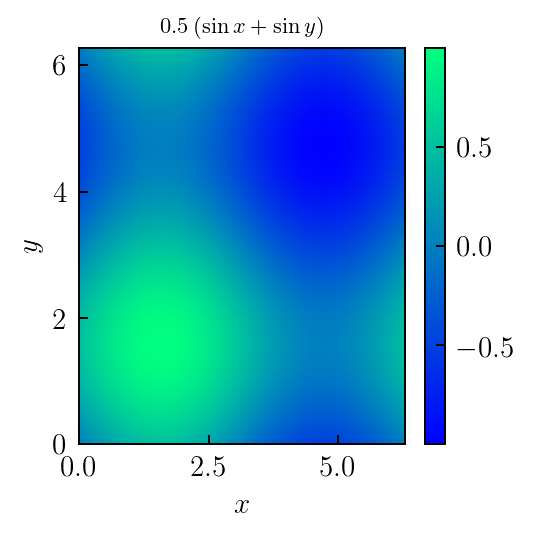

In [11]:
from codes.plot_utils import plot_color_map

plot_color_map(xgt, ygt, ft, xlim=[xmin,xmax], ylim=[xmin,xmax], 
                   xlabel = '$x$', ylabel = '$y$', cmap='winter', colorbar=True, 
                   plot_title=r'$0.5\,(\sin x+\sin y)$', 
                   figsize=3.0)


**Task 2b (15 points).** Although there is no convenient Scipy routine for polynomial interpolation in 2d, we can use the same approach as was used in Task 1a to construct interpolating polynomial in 2d, as is done in the following routine (a modified version of the routine provided <a href="https://stackoverflow.com/questions/33964913/equivalent-of-polyfit-for-a-2d-polynomial-in-python">here</a>). 

Write a routine that constructs 2D *polynomial* approximation of $\tilde{d}_L(z,\Omega_{\rm m0}, \Omega_\Lambda)$ for a given input single value of redshift $z$ and for ranges of the $\Omega_{\rm m0}$ and $\Omega_\Lambda)$ parameters of $\Omega_{\rm m0}\in [0.1]$ and $\Omega_\Lambda\in[0.,1]$. Just like for the spline in 2a, experiment with different training point spacings (for example, evenly spaced vs Chebyshev nodes) and try to find the spacing that reaches the target fractional accuracy of $10^{-4}$ with the smallest size of the training set. 

State your conclusions about the optimal method for approximating $\tilde{d}_L(z,\Omega_{\rm m0}, \Omega_\Lambda)$ supporting it with tests of fractional accuracy and plots, as needed. Each of the groups will make a brief presentation of their results in class Friday of next week.

In [12]:
def polyfit2d(xtr, ytr, ftr, kx=3, ky=3, order=None):
    '''
    Two dimensional polynomial fitting by least squares.
    Fits the functional form f(x,y) = z.

    Notes
    -----
    Resulting fit can be plotted with:
    np.polynomial.polynomial.polygrid2d(x, y, soln.reshape((kx+1, ky+1)))

    Parameters:
    ----------
    xtr, ytr: array-like, 1d
        xtr and ytr coordinates.
    ftr: 2d numpy array
        f(xgtr, ygtr) values evaluated on meshgrid of xtr and ytr vectors to fit by polynomial
    kx, ky: int, default is 3
        Polynomial order in x and y, respectively.
    order: int or None, default is None
        If None, all coefficients up to maxiumum kx, ky, ie. up to and including x^kx*y^ky, are considered.
        If int, coefficients up to a maximum of kx+ky <= order are considered.

    Returns:
    -------
    Return paramters from np.linalg.lstsq.

    soln: np.ndarray
        Array of polynomial coefficients.
    residuals: np.ndarray
    rank: int
    s: np.ndarray

    '''

    # grid coords
    x, y = np.meshgrid(xtr, ytr)
    # coefficient array, up to x^kx, y^ky
    coeffs = np.ones((kx+1, ky+1))

    # solve array
    V = np.zeros((coeffs.size, x.size))

    # construct Vandermonde matrix: for each coefficient produce array x^i, y^j
    for index, (j, i) in enumerate(np.ndindex(coeffs.shape)):
        # do not include powers greater than order
        if order is not None and i + j > order:
            arr = np.zeros_like(x)
        else:
            arr = coeffs[i, j] * x**i * y**j
        V[index] = arr.flatten()
        
    # do leastsq fitting and return leastsq result
    return np.linalg.lstsq(V.T, np.ravel(ftr), rcond=None)[0]

In [13]:
# be careful with polynomial order, results quickly become unstable as order increases
px, py = 7, 7 # polynomial order in x and y direction

# get coefficients of best 2d polynomial
a = polyfit2d(xtr, ytr, ftr, kx=px, ky=py, order=None)

In [14]:
# compute polynomial values on the grid of test points
ff = np.polynomial.polynomial.polyval2d(xgt, ygt, a.reshape((px+1,py+1)))

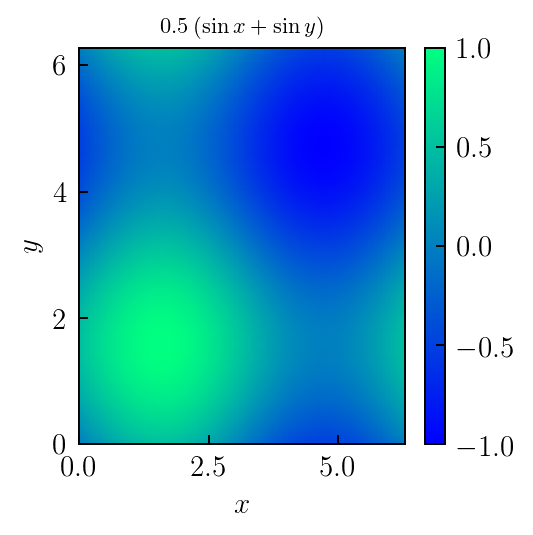

In [15]:
# plot approximating polynomial
plot_color_map(xgt, ygt, ff, xlim=[xmin,xmax], ylim=[xmin,xmax], 
                   xlabel = '$x$', ylabel = '$y$', cmap='winter', colorbar=True, 
                   plot_title=r'$0.5\,(\sin x+\sin y)$', 
                   figsize=3.0)

### Exercise 3 (extra-credit, 10 points): implementing spline interpolation as a Python class

Implementing a spline routine as a python class. In this exercise you would learn (or practice) object-oriented programming in python, which is particularly suited for this task. To learn how classes are defined and used in Python, see <a href="https://www.python-course.eu/python3_object_oriented_programming.php">this tutorial</a> or ask instructor or TAs.  

**Task.** Using the routines for calculation of spline coefficient vectors <tt>a, b, c, d</tt> and then the calculation of the actual spline values for an arbitrary input vector $x$  provided in this notebook above (routines <tt>cubic_spline_coefficients</tt> and <tt>cubic_spline</tt>) implement a class for spline interpolation that can be initialized and then used for an arbitrary input vector, similar to the way SciPy routines <a href="https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.interpolate.interp1d.html"><tt>interp1d</tt></a> and <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.UnivariateSpline.html"><tt>UnivariateSpline</tt></a> are used.  